In [25]:
## dependencies

In [26]:
#pip install country_converter --upgrade
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from datetime import date 
from datetime import datetime
import hvplot.pandas


Load the CSV Files

In [27]:
#Load the CSV file created into a Pandas DataFrame
hotel_df = pd.read_csv("Resources/filtered_hotel_bookings.csv")
country_df = pd.read_csv("Resources/countries_codes_and_coordinates.csv")

Clean the countries_codes_and_coordinates.csv.  This file has quotation marks which need to be removed

In [28]:
# Define the cleaning function
clean_function = lambda x: x.replace('"', '').strip() if isinstance(x, str) else x

# Apply the cleaning function to each column (Series) in the DataFrame
country_clean_df = country_df.copy()
for col in country_clean_df.columns:
    country_clean_df[col] = country_clean_df[col].map(clean_function)

# Dropping columns 'Alpha-2 code' and 'Numeric code'
country_clean_df = country_clean_df.drop(['Alpha-2 code', 'Numeric code'], axis=1)

# Renaming column 'Country' to 'Country Name'
country_clean_df.rename(columns={'Country': 'Country Name'}, inplace=True)

# Show the first few rows of the cleaned DataFrame
country_clean_df.head()

,Country Name,Alpha-3 code,Latitude (average),Longitude (average)
0,Afghanistan,AFG,33,65
1,Åland Islands,ALA,60.116667,19.9
2,Albania,ALB,41,20
3,Algeria,DZA,28,3
4,American Samoa,ASM,-14.3333,-170


Merge the files

In [29]:
#  hotel_country_df = pd.merge(hotel_df, country_clean_df, how='left', left_on='country', right_on='Alpha-3 code')
hotel_country_df = pd.merge(hotel_df, country_clean_df, how='left', 
                            left_on='country', right_on='Alpha-3 code', 
                            suffixes=('', '_from_country_clean'))

In [30]:
hotel_country_df = hotel_country_df.dropna(subset=['Country Name'])
hotel_country_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59342 entries, 0 to 59341
Data columns (total 40 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           59342 non-null  int64  
 1   hotel                           59342 non-null  object 
 2   is_canceled                     59342 non-null  int64  
 3   lead_time                       59342 non-null  int64  
 4   arrival_date_year               59342 non-null  int64  
 5   arrival_date_month              59342 non-null  object 
 6   arrival_date_week_number        59342 non-null  int64  
 7   arrival_date_day_of_month       59342 non-null  int64  
 8   stays_in_weekend_nights         59342 non-null  int64  
 9   stays_in_week_nights            59342 non-null  int64  
 10  adults                          59342 non-null  int64  
 11  children                        59342 non-null  float64
 12  babies                          

Create 3 columns
arrival_date - combine columns to get a date
nights_spent - add the stays in weekend + stays in week
amount_spent - amount spent per stay = nights_ spent * average day rate

In [31]:
hotel_country_df['arrival_date'] = pd.to_datetime(hotel_country_df['arrival_date_year'].astype(str) + '-' +
                                                  hotel_country_df['arrival_date_month'] + '-' +
                                                  hotel_country_df['arrival_date_day_of_month'].astype(str))

In [32]:
hotel_country_df['nights_spent'] = (hotel_country_df['stays_in_weekend_nights'] + hotel_country_df['stays_in_week_nights'])

In [33]:
hotel_country_df['amount_spent'] = (hotel_country_df['nights_spent'] * hotel_country_df['adr'])

In [34]:
# Check the DataFrame with the new column
hotel_country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59342 entries, 0 to 59341
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   index                           59342 non-null  int64         
 1   hotel                           59342 non-null  object        
 2   is_canceled                     59342 non-null  int64         
 3   lead_time                       59342 non-null  int64         
 4   arrival_date_year               59342 non-null  int64         
 5   arrival_date_month              59342 non-null  object        
 6   arrival_date_week_number        59342 non-null  int64         
 7   arrival_date_day_of_month       59342 non-null  int64         
 8   stays_in_weekend_nights         59342 non-null  int64         
 9   stays_in_week_nights            59342 non-null  int64         
 10  adults                          59342 non-null  int64         
 11  ch

Euros spent per stay from July 1 2015 to August 31 2017
conclusion: no regression analysis --To get a regression another variable possibly seasons, must be added

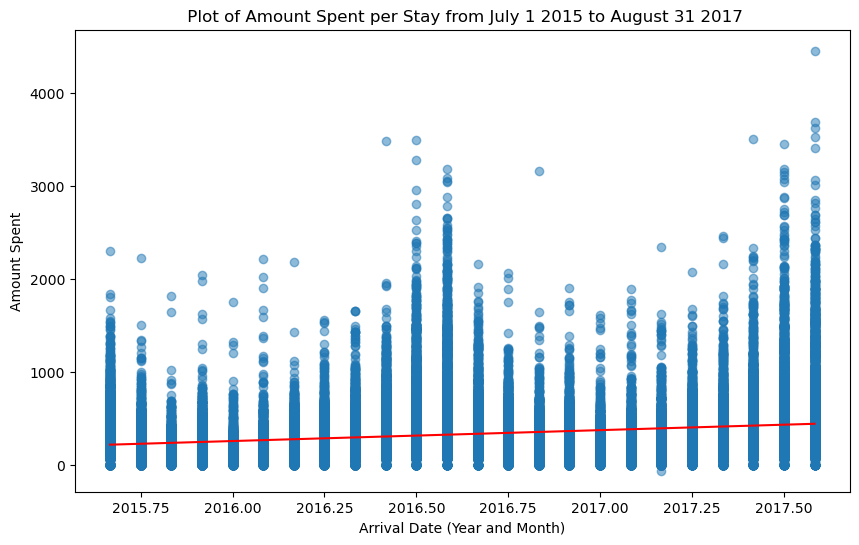

In [35]:
# First filter for check-outs and Resort Hotel only
filtered_df = hotel_country_df[(hotel_country_df['reservation_status'] == 'Check-Out')]

# Instead of creating a new DataFrame, create a copy explicitly to avoid SettingWithCopyWarning
filtered_df = filtered_df.copy()

# Since 'arrival_date_month' is a categorical variable, it must be converted into a numeric form
months_mapping = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}
filtered_df.loc[:, 'arrival_date_month_numeric'] = filtered_df['arrival_date_month'].map(months_mapping)

# Creating a new column 'arrival_date_numeric' by adding year as thousands plus the month as a fractional year
filtered_df.loc[:, 'arrival_date_numeric'] = filtered_df['arrival_date_year'] + \
                                             (filtered_df['arrival_date_month_numeric'] - 1) / 12

# Perform the regression analysis with 'amount_spent' as dependent variable
# and 'arrival_date_numeric' as independent variable
slope, intercept, r_value, p_value, std_err = linregress(filtered_df['arrival_date_numeric'],
                                                          filtered_df['amount_spent'])

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_df['arrival_date_numeric'], filtered_df['amount_spent'], alpha=0.5)
# Create values for the regression line
regression_line_y_vals = slope * filtered_df['arrival_date_numeric'] + intercept

# Plot the regression line
plt.plot(filtered_df['arrival_date_numeric'], regression_line_y_vals, color='red')


plt.title(" Plot of Amount Spent per Stay from July 1 2015 to August 31 2017")
plt.xlabel("Arrival Date (Year and Month)")
plt.ylabel("Amount Spent")
plt.show()

Average Daily Rate (ADR) vs. Week of the Year
Conclusion  The City hotel as steady occupancy throught the year
The Resort hotel has a peak season in the summer and around the Christmas break and year end

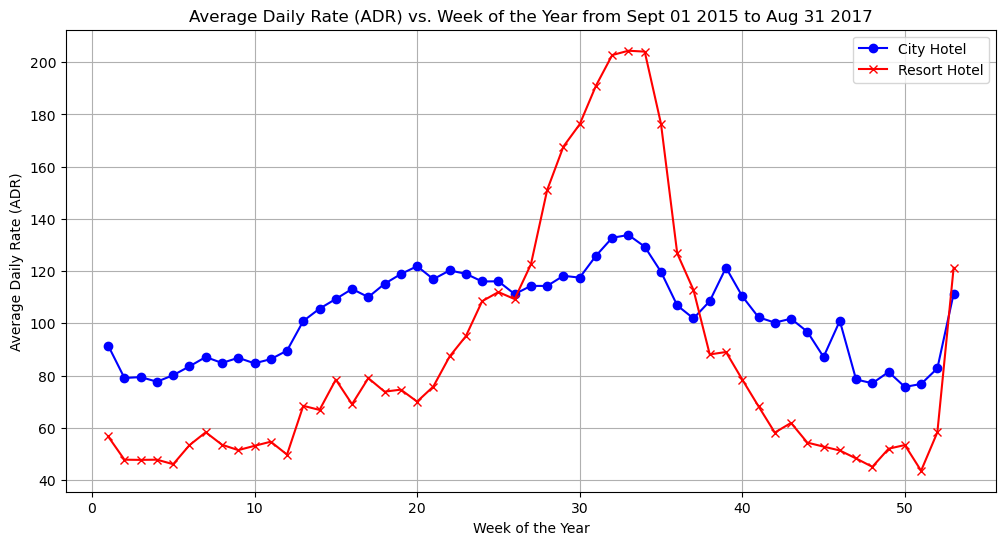

In [36]:
start_date = datetime(2015, 9, 1)
end_date = datetime(2017, 8, 31)


# Create the plot
plt.figure(figsize=(12, 6))# Filter the main DataFrame for check-outs only and make a copy to avoid SettingWithCopyWarning
check_outs_df = hotel_country_df[
    (hotel_country_df['reservation_status'] == 'Check-Out') &
    (hotel_country_df['arrival_date'] >= start_date) &
    (hotel_country_df['arrival_date'] <= end_date)
].copy()

# Proceed with filtering for each hotel type
# Filter DataFrame for City Hotel and calculate the mean ADR per week
city_hotel_data = check_outs_df[check_outs_df['hotel'] == 'City Hotel']
city_hotel_weekly_adr = city_hotel_data.groupby('arrival_date_week_number')['adr'].mean()

# Filter DataFrame for Resort Hotel and calculate the mean ADR per week
resort_hotel_data = check_outs_df[check_outs_df['hotel'] == 'Resort Hotel']
resort_hotel_weekly_adr = resort_hotel_data.groupby('arrival_date_week_number')['adr'].mean()


# Plot City Hotel in blue
plt.plot(city_hotel_weekly_adr.index, city_hotel_weekly_adr.values, label='City Hotel', color='blue', marker='o')

# Plot Resort Hotel in red
plt.plot(resort_hotel_weekly_adr.index, resort_hotel_weekly_adr.values, label='Resort Hotel', color='red', marker='x')

# Add titles and labels
plt.title('Average Daily Rate (ADR) vs. Week of the Year from Sept 01 2015 to Aug 31 2017')
plt.xlabel('Week of the Year')
plt.ylabel('Average Daily Rate (ADR)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()





Total amount spent by country

Observation which require further inquiry 
1. Uk and Ireland spend a lot of money on resorts 
2. The French spend many more Euros on City hotel than resorts

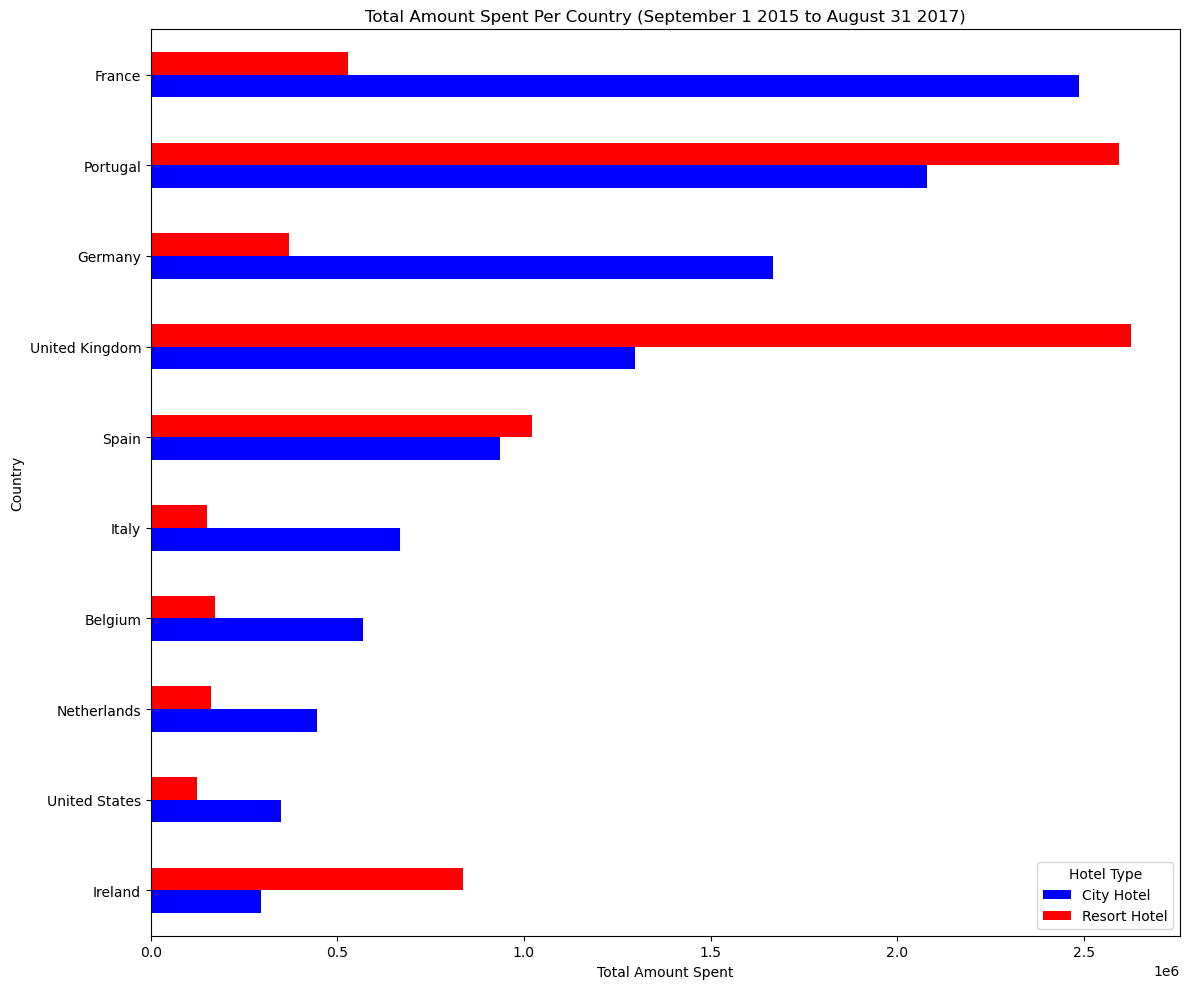

In [37]:
start_date = datetime(2015, 9, 1)
end_date = datetime(2017, 8, 31)

check_outs_df = hotel_country_df[
    (hotel_country_df['reservation_status'] == 'Check-Out') &
    (hotel_country_df['arrival_date'] >= start_date) &
    (hotel_country_df['arrival_date'] <= end_date)
].copy()


# Group by 'country' and 'hotel' and sum the 'amount_spent', then sort by the sum
grouped_data = check_outs_df.groupby(['Country Name', 'hotel'])['amount_spent'].sum().reset_index()

# Get the top 25 countries by amount spent
top_countries = grouped_data.groupby('Country Name')['amount_spent'].sum().nlargest(10).index

# Filter the grouped data for the top countries
top_grouped_data = grouped_data[grouped_data['Country Name'].isin(top_countries)]

# Pivot data to have hotels as columns and countries as rows
pivot_data = top_grouped_data.pivot(index='Country Name', columns='hotel', values='amount_spent')

# Plotting
fig, ax = plt.subplots(figsize=(12, 10))

# Horizontal bar plot, City Hotel in blue, Resort Hotel in red
pivot_data.sort_values(by='City Hotel', ascending=True).plot(kind='barh', color={'City Hotel': 'blue', 'Resort Hotel': 'red'}, ax=ax)

# Add titles and labels
plt.title('Total Amount Spent Per Country (September 1 2015 to August 31 2017)')
plt.xlabel('Total Amount Spent')
plt.ylabel('Country')
plt.legend(title='Hotel Type')
plt.tight_layout()

# Show the plot
plt.show()

Amount spent over the two year period by market segment (using matplotlib)
Conclusion 
Online segment is the preferred segment in both the City & Resosrt Hotel

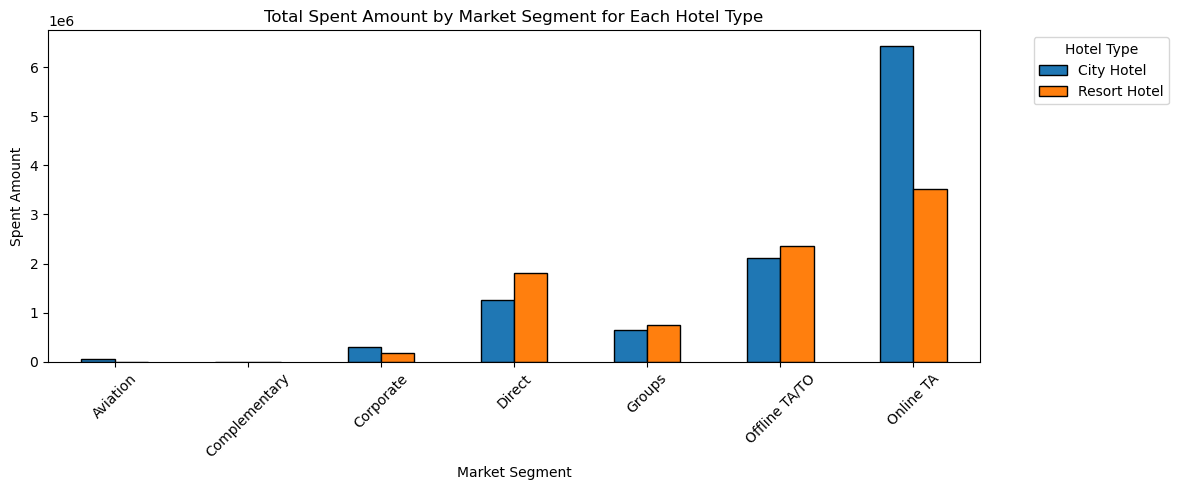

In [38]:
# Filter the DataFrame for rows where 'reservation_status' is 'Check-Out'
filtered_df = hotel_country_df.loc[
    (hotel_country_df['reservation_status'] == 'Check-Out')
].copy()

# Group by 'market_segment' and 'hotel', then sum up the 'amount_spent'
segment_group = filtered_df.groupby(['market_segment', 'hotel'])['amount_spent'].sum().unstack(fill_value=0)

# Plot the histogram for each market segment with both 'City Hotel' and 'Resort Hotel'
segment_group.plot(kind='bar', figsize=(10, 5), edgecolor='black')
plt.xlabel('Market Segment')
plt.ylabel('Spent Amount')
plt.title('Total Spent Amount by Market Segment for Each Hotel Type')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.tight_layout()  # Adjust the layout for better fit
plt.legend(title='Hotel Type', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place the legend outside the plot
plt.show()

Amount spent over the two year period by market segment (using hvplot)

In [39]:
# Filter the DataFrame for rows where 'reservation_status' is 'Check-Out'
filtered_df = hotel_country_df.loc[
    hotel_country_df['reservation_status'] == 'Check-Out'
].copy()

# Convert 'amount_spent' to millions of euros
filtered_df['amount_spent_millions'] = filtered_df['amount_spent'] / 1_000_000

# Group by 'market_segment' then 'hotel', and sum up the 'amount_spent_millions'
segment_group = filtered_df.groupby(['market_segment', 'hotel'])['amount_spent_millions'].sum().reset_index()

# Use hvPlot to plot the bar chart
segment_group_plot = segment_group.hvplot.bar(
    x='market_segment',
    y='amount_spent_millions',
    by='hotel',
    height=400,
    width=800,
    xlabel="Market Segment",
    ylabel="Spent Amount (in millions of Euros)",
    title="Total Spent Amount for Each Hotel within Each Market Segment",
    rot=45
)

# Render the plot.
segment_group_plot.opts(invert_axes=False)

:Bars   [market_segment,hotel]   (amount_spent_millions)

Amount Spent vs Room Nights


Observations


In the Resort hotel spend on 7 night stays is the greatest


In the City hotel spend was greatest on a 3 day stay

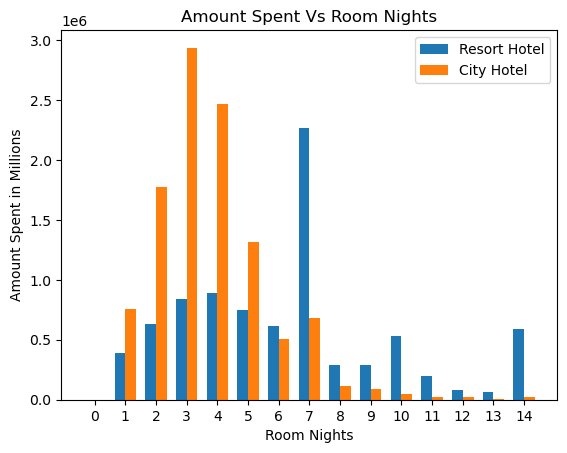

In [40]:
# Filter for rows where the reservation status is 'Check-Out'
checked_out_df = hotel_country_df[hotel_country_df['reservation_status'] == "Check-Out"]

# Further filter for rows where nights_spent is less than or equal to 14
checked_out_df = checked_out_df[checked_out_df['nights_spent'] <= 14]

# Preparing the data for clustering by hotel type
resort_hotel = checked_out_df[checked_out_df['hotel'] == 'Resort Hotel']
city_hotel = checked_out_df[checked_out_df['hotel'] == 'City Hotel']

# Find the total amount_spent for each number of nights_spent for each hotel
resort_hotel_grouped = resort_hotel.groupby('nights_spent')['amount_spent'].sum().reset_index()
city_hotel_grouped = city_hotel.groupby('nights_spent')['amount_spent'].sum().reset_index()

# For the bar chart, we ensure that both dataframes have the same nights_spent values
nights_spent_values = sorted(set(resort_hotel_grouped['nights_spent']) | set(city_hotel_grouped['nights_spent']))
resort_hotel_grouped = resort_hotel_grouped.set_index('nights_spent').reindex(nights_spent_values).reset_index()
city_hotel_grouped = city_hotel_grouped.set_index('nights_spent').reindex(nights_spent_values).reset_index()

# Filling NaN values with 0 as some nights may not have entries in both hotel types
resort_hotel_grouped = resort_hotel_grouped.fillna(0)
city_hotel_grouped = city_hotel_grouped.fillna(0)

# Plotting the bar chart
bar_width = 0.35
index = np.arange(len(nights_spent_values))

fig, ax = plt.subplots()
bar1 = ax.bar(index, resort_hotel_grouped['amount_spent'], bar_width, label='Resort Hotel')
bar2 = ax.bar(index + bar_width, city_hotel_grouped['amount_spent'], bar_width, label='City Hotel')

# Adding labels and title
ax.set_xlabel('Room Nights')
ax.set_ylabel('Amount Spent in Millions')
ax.set_title('Amount Spent Vs Room Nights')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(nights_spent_values)
ax.legend()

# Showing the plot
plt.show()

## additional work not deemed **interesting**

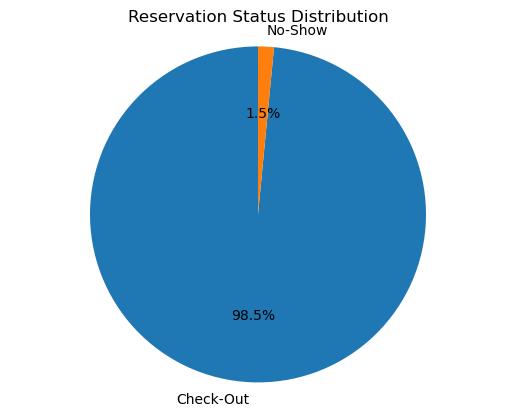

In [41]:


# Count the occurrences of each reservation status
status_counts = hotel_country_df['reservation_status'].value_counts()

# Create the pie chart
fig, ax = plt.subplots()
ax.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Add a title
plt.title('Reservation Status Distribution')

# Show the pie chart
plt.show()


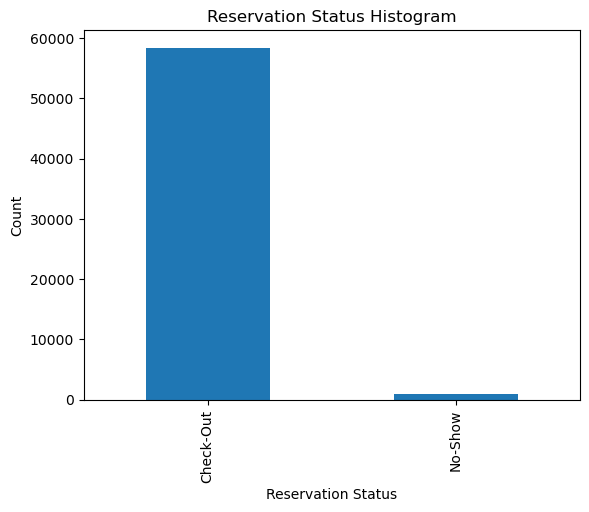

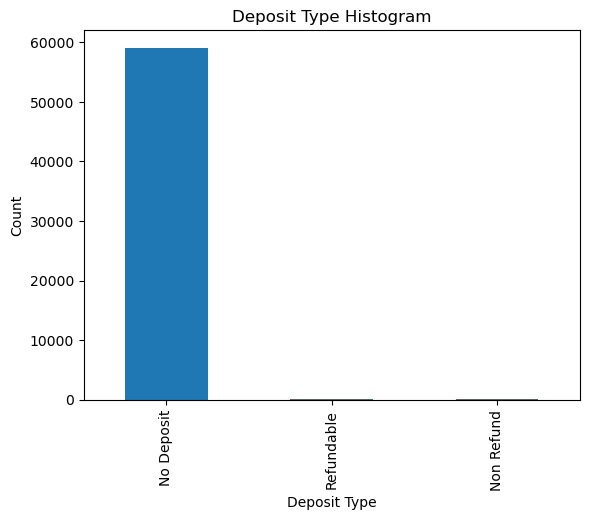

In [42]:
hotel_country_df["reservation_status"].value_counts().plot.bar()
plt.xlabel("Reservation Status")
plt.ylabel("Count")
plt.title("Reservation Status Histogram")
plt.show()

hotel_country_df["deposit_type"].value_counts().plot.bar()
plt.xlabel("Deposit Type")
plt.ylabel("Count")
plt.title("Deposit Type Histogram")
plt.show()

In [43]:
# Filtering the DataFrame for check-outs only
check_outs_df = hotel_country_df.loc[hotel_country_df['reservation_status'] == 'Check-Out'].copy()

# Calculate weekend spend and weekday spend
check_outs_df.loc[:, 'weekend_spend'] = check_outs_df['adr'] * check_outs_df['stays_in_weekend_nights']
check_outs_df.loc[:, 'weekday_spend'] = check_outs_df['adr'] * check_outs_df['stays_in_week_nights']

# Summing up weekend and weekday spend for both hotel types
summary_df = check_outs_df.groupby('hotel')[['weekend_spend', 'weekday_spend']].sum()

# Plotting the bar chart
summary_df_plot = summary_df.hvplot.bar(rot=45, width=500, height=400, title="Total Spend for Resort and City Hotels")

# Render the plot. Note: If you are running this in a Jupyter notebook, you might need to use 'hvplot.show(summary_df_plot)'.
summary_df_plot

:Bars   [hotel,Variable]   (value)

In [44]:
# Filter the DataFrame for rows where 'reservation_status' is 'Check-Out'
filtered_df = hotel_country_df.loc[
    hotel_country_df['reservation_status'] == 'Check-Out'
].copy()

# Convert 'amount_spent' to millions of euros
filtered_df['amount_spent_millions'] = filtered_df['amount_spent'] / 1_000_000

# Group by 'market_segment' then 'hotel', and sum up the 'amount_spent_millions'
segment_group = filtered_df.groupby(['market_segment', 'hotel'])['amount_spent_millions'].sum().reset_index()

# Use hvPlot to plot the bar chart
segment_group_plot = segment_group.hvplot.bar(
    x='market_segment',
    y='amount_spent_millions',
    by='hotel',
    height=500,
    width=900,
    xlabel="Market Segment",
    ylabel="Spent Amount (in millions of Euros)",
    title="Total Spent Amount by Hotels within Each Market Segment",
    
)

# Render the plot.
segment_group_plot.opts(invert_axes=False)

:Bars   [market_segment,hotel]   (amount_spent_millions)

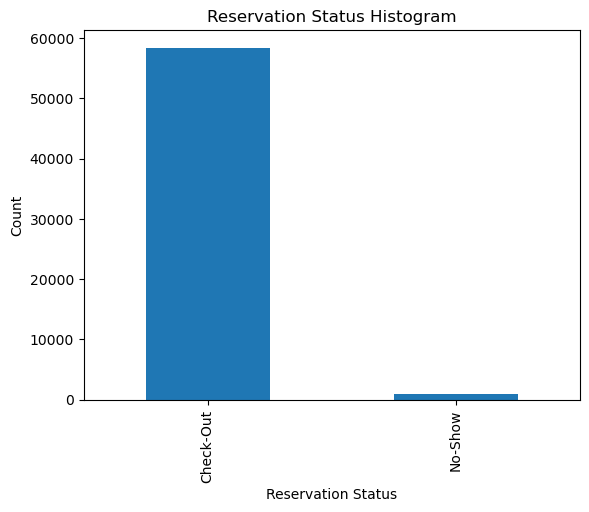

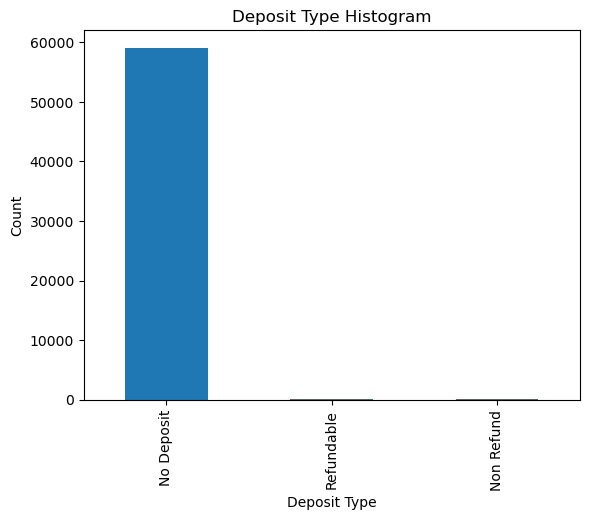

In [45]:
hotel_country_df["reservation_status"].value_counts().plot.bar()
plt.xlabel("Reservation Status")
plt.ylabel("Count")
plt.title("Reservation Status Histogram")
plt.show()

hotel_country_df["deposit_type"].value_counts().plot.bar()
plt.xlabel("Deposit Type")
plt.ylabel("Count")
plt.title("Deposit Type Histogram")
plt.show()

In [46]:
# Filter the DataFrame for rows where 'reservation_status' is 'Check-Out'
filtered_df = hotel_country_df.loc[
    hotel_country_df['reservation_status'] == 'Check-Out'
].copy()

# Convert 'amount_spent' to millions of euros
filtered_df['amount_spent_millions'] = filtered_df['amount_spent'] / 1_000_000

# Group by 'market_segment' then 'hotel', and sum up the 'amount_spent_millions'
segment_group = filtered_df.groupby(['market_segment', 'hotel'])['amount_spent_millions'].sum().reset_index()

# Use hvPlot to plot the bar chart
segment_group_plot = segment_group.hvplot.bar(
    x='market_segment',
    y='amount_spent_millions',
    by='hotel',
    height=400,
    width=800,
    xlabel="Market Segment",
    ylabel="Spent Amount (in millions of Euros)",
    title="Total Spent Amount for Each Hotel within Each Market Segment",
    rot=45
)

# Render the plot.
segment_group_plot.opts(invert_axes=False)

:Bars   [market_segment,hotel]   (amount_spent_millions)